In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_square_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}
dic1 = {'Yes':1,'No':0}
dic2 = {'In State':1,'Out of State':0}
dic3 = {'Owner':1,'1st Gen':0}
dic4 = {'Couple':1,'Single':0}
dic5 = {'Weekday':0, 'Weekend':1}
dic6 = {2017:0, 2018:1}

# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)
df['Homeowner']=df['Homeowner'].replace(dic1)
df['InState']=df['InState'].replace(dic2)
df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)
df['relationStatus']=df['relationStatus'].replace(dic4)
df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)
df['Year of TourDate']=df['Year of TourDate'].replace(dic6)


df = df[df['ResultOfTour']==1]

print(df.info())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 2865 entries, 256888 to 385414
Data columns (total 17 columns):
?TourContractGeneration       2865 non-null int64
?TourGeneration               2865 non-null int64
Age                           2865 non-null int64
AgentLine                     2865 non-null object
BookingWindow                 2865 non-null object
FirstGenVsOwner               2865 non-null int64
HHIncomeRanges                2865 non-null object
Homeowner                     2865 non-null int64
InState                       2865 non-null int64
Month of TourDate             2865 non-null object
Programs (Budget)             2865 non-null object
relationStatus                2865 non-null int64
ResultOfTour                  2865 non-null int64
TourSeason                    2865 non-null object
WeekdayOrWeekend              2865 non-null int64
Year of TourDate              2865 non-null int64
NetVolumePlusNonGoodVolume    2865 non-null float64
dtypes: float64(1), int64(10

In [4]:
# remove outliers from predicting model:
df['NetVolumePlusNonGoodVolume'] = (df['NetVolumePlusNonGoodVolume']+1).apply(np.sqrt)
print(len(df))
pU, pL = np.percentile(df['NetVolumePlusNonGoodVolume'], [99.85 ,0.15])
df = df.loc[df['NetVolumePlusNonGoodVolume'] <= (pU)]
df = df.loc[df['NetVolumePlusNonGoodVolume'] >= (pL)]
df['NetVolumePlusNonGoodVolume'] = np.power(df['NetVolumePlusNonGoodVolume'],2)
print(len(df))

2865
2855


In [5]:
print(len(df))
pU, pL = np.percentile(df['Age'], [99.85 ,0.15])
df = df.loc[df['Age'] <= (pU)]
df = df.loc[df['Age'] >= (pL)]
print(len(df))

2855
2847


In [6]:



dfX = df.drop(['ResultOfTour', 'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['AgentLine', 'BookingWindow', 'HHIncomeRanges','Month of TourDate', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])

scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])

scaler4 = StandardScaler()
scaler4.fit(df[['NetVolumePlusNonGoodVolume']])
df['NetVolumePlusNonGoodVolume'] = scaler4.transform(df[['NetVolumePlusNonGoodVolume']])


X_train, X_test, y_train, y_test = train_test_split(dfX, df['NetVolumePlusNonGoodVolume'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train
 



print(dfX1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 354896 to 354059
Data columns (total 54 columns):
?TourContractGeneration                        2277 non-null float64
?TourGeneration                                2277 non-null float64
Age                                            2277 non-null float64
FirstGenVsOwner                                2277 non-null int64
Homeowner                                      2277 non-null int64
InState                                        2277 non-null int64
relationStatus                                 2277 non-null int64
WeekdayOrWeekend                               2277 non-null int64
Year of TourDate                               2277 non-null int64
AgentLine_Breck                                2277 non-null uint8
AgentLine_Colorado                             2277 non-null uint8
AgentLine_Other Line                           2277 non-null uint8
BookingWindow_Inside 2 Days                    2277 non-null uint8
BookingWi

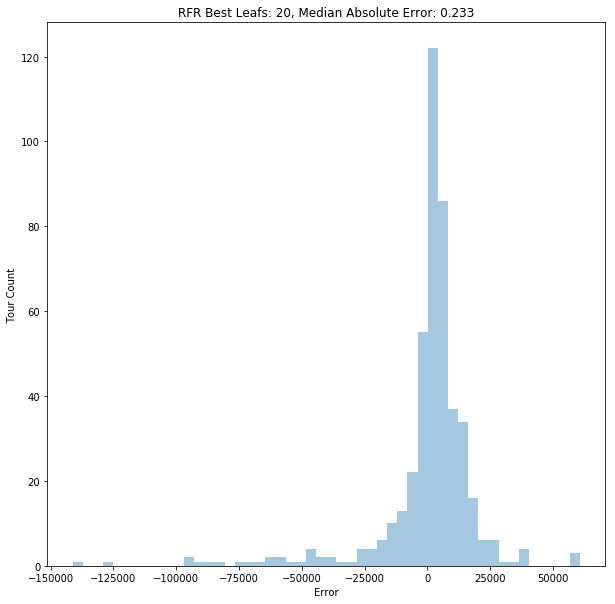

In [7]:
#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)

bestLRFR =0
bestR2RFR=1
bestFIRFR = []
bestDiffRFR = []
i=0
#make cross validation of K values and kfold
Ls = [1,5,10,20,40]
np.random.shuffle(Ls)
kf = KFold(5, random_state= 0)


for train, test in kf.split(dfX1,dfY1):
    rfr = RandomForestRegressor(n_estimators=1000,min_samples_leaf=Ls[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = median_absolute_error(dfY1.iloc[test.tolist()], preds)
    if score < bestR2RFR:
        bestR2RFR = score
        bestLRFR = Ls[i]
        bestFIRFR = rfr.feature_importances_
        bestDiffRFR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
  
sns.distplot(bestDiffRFR, kde=False)
plt.ylabel('Tour Count')
plt.xlabel('Error')
plt.title('RFR Best Leafs: ' + str(bestLRFR)+ ', Median Absolute Error: '+ str(round(bestR2RFR,3)))
plt.show()



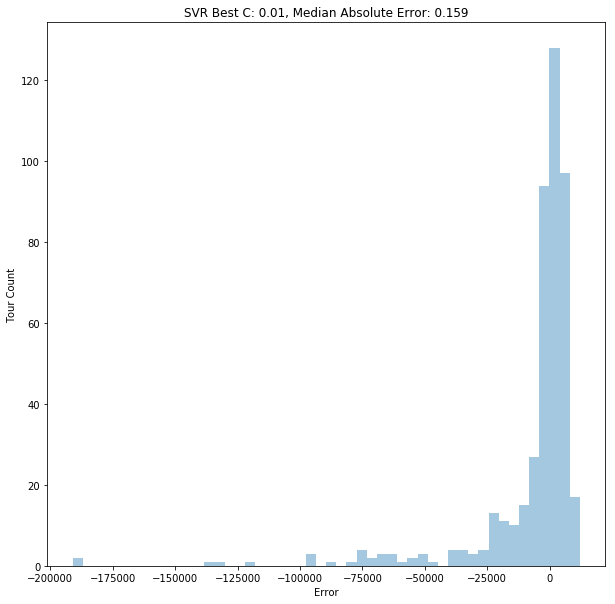

In [8]:
from sklearn.svm import SVR

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)

bestCSVR = 0
bestR2SVR = 1
bestDiffSVR = []

i=0
#make cross validation of K values and kfold
Cs = [0.01, 0.1, 1,10,100]
np.random.shuffle(Cs)
kf = KFold(5, random_state= 42)


for train, test in kf.split(dfX1,dfY1):
    rfr = SVR(C=Cs[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = median_absolute_error(dfY1.iloc[test.tolist()], preds)
    if score < bestR2SVR:
        bestR2SVR = score
        bestCSVR = Cs[i]
        bestDiffSVR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
sns.distplot(bestDiffSVR, kde=False)
plt.ylabel('Tour Count')
plt.xlabel('Error')
plt.title('SVR Best C: ' + str(bestCSVR)+ ', Median Absolute Error: '+ str(round(bestR2SVR,3)))
plt.show()



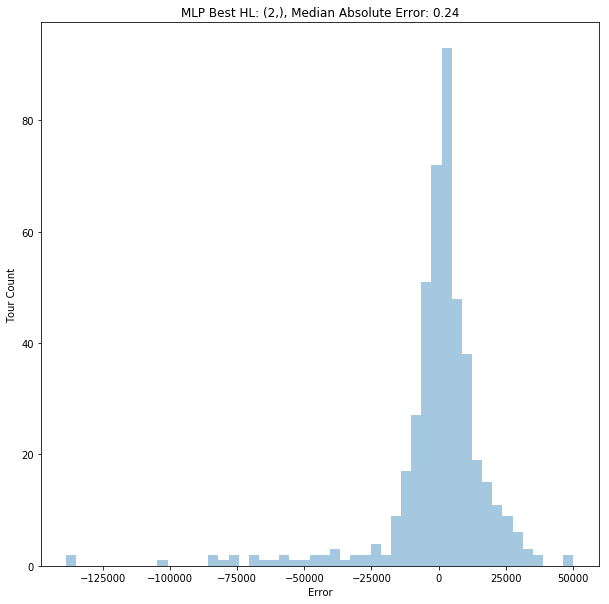

In [9]:
from sklearn.neural_network import MLPRegressor
import itertools 

bestHL = 0
bestR2HL = 1
bestDiffMLP = []
i = 0

colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,5,10,20,40),repeat=1)]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


np.random.shuffle(HLs)
kf = KFold(5, random_state= 42)


for train, test in kf.split(dfX1,dfY1):
    rfr = MLPRegressor(hidden_layer_sizes=HLs[i])
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict(dfX1.iloc[test.tolist()])
    score = median_absolute_error(dfY1.iloc[test.tolist()], preds)
    if score < bestR2HL:
        bestR2HL = score
        bestHL = HLs[i]
        bestDiffMLP = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(dfY1.iloc[test.tolist()] )
    i += 1 
    
    
sns.distplot(bestDiffMLP, kde=False)
plt.ylabel('Tour Count')
plt.xlabel('Error')
plt.title('MLP Best HL: ' + str(bestHL)+ ', Median Absolute Error: '+ str(round(bestR2HL,3)))
plt.show()

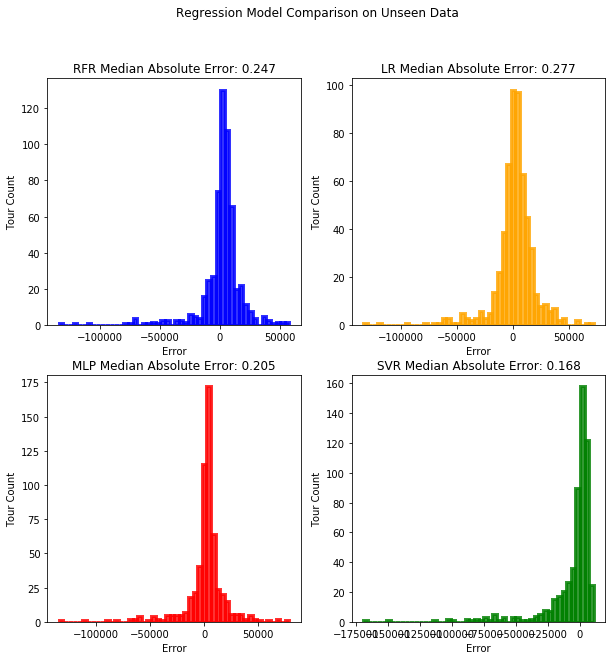

In [10]:
lr = LinearRegression()
lr.fit(dfX1,dfY1)
preds = lr.predict(X_test)
lrScore = median_absolute_error(y_test, preds)
diffLR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(y_test )

#random forest best model 
rf = RandomForestRegressor(n_estimators=1000,min_samples_leaf =bestLRFR,random_state=42)
rf.fit(dfX1,dfY1)
preds = rf.predict(X_test)
rfrScore = median_absolute_error(y_test, preds)
diffRFR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(y_test )


#support vector best model
svr = SVR(C=bestCSVR)
svr.fit(dfX1,dfY1)
preds = svr.predict(X_test)
svrScore = median_absolute_error(y_test, preds)
diffSVR = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(y_test )

# mlp regressor
mlp = MLPRegressor(hidden_layer_sizes=bestHL)
mlp.fit(dfX1,dfY1)
preds = mlp.predict(X_test)
mlpScore = median_absolute_error(y_test, preds)
diffMLP = scaler4.inverse_transform(preds ) - scaler4.inverse_transform(y_test )
plt.subplot(2,2,1)
plt.title('RFR Median Absolute Error: '+ str(round(rfrScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffRFR, kde=False, color = 'Blue', hist_kws=dict(alpha=0.8,edgecolor="Blue", linewidth=3) )
plt.subplot(2,2,2)
plt.title('LR Median Absolute Error: '+ str(round(lrScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffLR, kde=False, color = 'Orange',   hist_kws=dict(alpha=0.8,edgecolor="Orange", linewidth=3))
plt.subplot(2,2,3)
plt.title('MLP Median Absolute Error: '+ str(round(mlpScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffMLP, kde=False, color = 'Red',   hist_kws=dict(alpha=0.8,edgecolor="Red", linewidth=3))
plt.subplot(2,2,4)
plt.title('SVR Median Absolute Error: '+ str(round(svrScore,3)))
plt.ylabel('Tour Count')
plt.xlabel('Error')
sns.distplot(diffSVR, kde=False, color = 'Green', hist_kws=dict(alpha=0.8,edgecolor="Green", linewidth=3))
plt.suptitle('Regression Model Comparison on Unseen Data')
plt.show()

In [11]:
print('Random Forest Regression Feature Importances: ')
print()
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(str(round(x,4)),'\t: ',str(y) )

Random Forest Regression Feature Importances: 

0.2538 	:  InState
0.2506 	:  HHIncomeRanges_350k to 500k
0.1409 	:  HHIncomeRanges_Over 500k
0.0644 	:  ?TourGeneration
0.0619 	:  Age
0.0493 	:  HHIncomeRanges_200k to 349k
0.0294 	:  Programs (Budget)_(14) Summit County OPC
0.0293 	:  Month of TourDate_March
0.0284 	:  ?TourContractGeneration
0.0114 	:  Year of TourDate
0.0112 	:  HHIncomeRanges_90k to 149k
0.0095 	:  TourSeason_Spring
0.0091 	:  HHIncomeRanges_150k to 199k
0.006 	:  Programs (Budget)_(09) GL7 Inhouse
0.0052 	:  BookingWindow_Inside 2 Days
0.0045 	:  TourSeason_Winter
0.0044 	:  HHIncomeRanges_70k to 89k
0.0032 	:  AgentLine_Colorado
0.0025 	:  BookingWindow_Inside Week
0.0025 	:  WeekdayOrWeekend
0.0023 	:  FirstGenVsOwner
0.0022 	:  TourSeason_Summer
0.0021 	:  Programs (Budget)_(12) Outbound Telemarktng
0.0018 	:  BookingWindow_Inside Month
0.0017 	:  Month of TourDate_February
0.0016 	:  Programs (Budget)_(21) GTL In House
0.0014 	:  AgentLine_Breck
0.0013 	:  Agen

In [12]:
print(np.mean(scaler4.inverse_transform(svr.predict(X_test))))
print(np.min(scaler4.inverse_transform(svr.predict(X_test))))
print(np.max(scaler4.inverse_transform(svr.predict(X_test))))

18138.69746361948
14945.679326342091
22050.813973398395


In [13]:
print(np.mean(scaler4.inverse_transform(lr.predict(X_test))))
print(np.min(scaler4.inverse_transform(lr.predict(X_test))))
print(np.max(scaler4.inverse_transform(lr.predict(X_test))))

25767.784324496803
-3602.524836502216
93956.754952712


In [14]:
print(np.mean(scaler4.inverse_transform(rf.predict(X_test))))
print(np.min(scaler4.inverse_transform(rf.predict(X_test))))
print(np.max(scaler4.inverse_transform(rf.predict(X_test))))

25800.23715771904
14480.076098503894
89063.2468633099


In [15]:
print(np.mean(scaler4.inverse_transform(mlp.predict(X_test))))
print(np.min(scaler4.inverse_transform(mlp.predict(X_test))))
print(np.max(scaler4.inverse_transform(mlp.predict(X_test))))

25737.658993406912
11731.225726267303
100167.65823084392


In [16]:
print(np.mean(scaler4.inverse_transform(y_test)))
print(np.min(scaler4.inverse_transform(y_test)))
print(np.max(scaler4.inverse_transform(y_test)))

24120.197315789475
7001.0
189686.0
